In [4]:
import tensorflow as tf
from keras.models import load_model
import efficientnet.keras as efn
import pandas as pd
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
from flask import render_template
from flask import Flask

# Funciones necesarias

In [2]:
def rle2mask(rle, width, target_size=None):
    if target_size == None:
        target_size = width

    rle = np.array(list(map(int, rle.split())))
    label = np.zeros((width*width))
    
    for start, end in zip(rle[::2], rle[1::2]):
        label[start:start+end] = 1
        
    #Convert label to image
    label = Image.fromarray(label.reshape(width, width))
    #Resize label
    label = label.resize((target_size, target_size))
    label = np.array(label).astype(float)
    #rescale label
    label = np.round((label - label.min())/(label.max() - label.min()))
    
    return label.T

def mask2rle(mask, orig_dim=160):
    #Rescale image to original size
    size = int(len(mask.flatten())**.5)
    n = Image.fromarray(mask.reshape((size, size))*255.0)
    n = n.resize((orig_dim, orig_dim))
    n = np.array(n).astype(np.float32)
    #Get pixels to flatten
    pixels = n.T.flatten()
    #Round the pixels using the half of the range of pixel value
    pixels = (pixels-min(pixels) > ((max(pixels)-min(pixels))/2)).astype(int)
    pixels = np.nan_to_num(pixels) #incase of zero-div-error
    
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0]
    runs[1::2] -= runs[::2]
    
    return ' '.join(str(x) for x in runs)
    
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(tf.cast(y_true, tf.float32), y_pred) + 0.5 * dice_loss(tf.cast(y_true, tf.float32), y_pred)

def weighted_loss(y_true, y_pred):
    # Calculate the base loss
    ce = K.sparse_categorical_crossentropy(y_true, y_pred)
    # Apply the weights
    one_weight = 1.0
    zero_weight = 1e-2
    weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
    weight_vector = K.squeeze(weight_vector, axis=-1)
    weighted_ce = weight_vector * ce

    # Return the mean error
    return K.mean(weighted_ce)

In [3]:
class ImageDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size=32, train=False, size=256):
        self.df = df.reset_index(drop=True)
        self.dim = size
        self.train = train
        if self.train: self.batch_size = batch_size // 4
        else: self.batch_size = batch_size
        self.pref = 'train'
    
    def __len__(self):
        return np.ceil(len(self.df) / self.batch_size).astype(int)
    
    def on_epoch_end(self):
        if self.train: #Reshuffle train on end of epoch
            self.df = self.df.sample(frac=1.0).reset_index(drop=True)
            
    def __getitem__(self, idx):
        batch_x = self.df.iloc[idx*self.batch_size:(idx+1)*self.batch_size].id.values
        
        if not self.train:
            X = np.zeros((batch_x.shape[0], self.dim, self.dim, 3))
            
            for i in range(batch_x.shape[0]):
                image = Image.open(f"./{self.pref}_images/{batch_x[i]}.tiff")
                image = image.resize((self.dim, self.dim))
                image = np.array(image) / 255.
                X[i,] = image
                
            return X
                
        else:
            batch_y = self.df.iloc[idx*self.batch_size:(idx+1)*self.batch_size].rle.values
            batch_w = self.df.iloc[idx*self.batch_size:(idx+1)*self.batch_size].img_width.values
            #print(batch_y, batch_w)
            X = np.zeros((batch_x.shape[0]*4, self.dim, self.dim, 3))
            Y = np.zeros((batch_x.shape[0]*4, self.dim, self.dim, 1))
            
            for i in range(batch_x.shape[0]):
                image = Image.open(f"./{self.pref}_images/{batch_x[i]}.tiff")
                image = image.resize((self.dim, self.dim))
                image = np.array(image)
                #image = np.array(image) / 255
                rle = rle2mask(batch_y[i], batch_w[i], self.dim)
                rle = rle.reshape((self.dim, self.dim, 1))

                for n, (h, v) in enumerate([(0, 0), (0, 1), (1, 0), (1, 1)]):
                    X[i*4 + n, :, :, :], Y[i*4 + n, :, :, :] = self.augumention(image,rle)
                    
            return X, Y#.reshape(Y.shape[:-1])
                
    def getAuguments(self):
        auguments = [
                A.Blur(blur_limit=7, always_apply=False, p=0.5),
                A.CLAHE(clip_limit=5.0, tile_grid_size=(8, 8), always_apply=False, p=0.66),
                A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
                A.Posterize (num_bits=6, p=0.3),
                A.RandomGamma (gamma_limit=(50, 300), p=0.3),    
                A.Sharpen (alpha=(0.2, 0.7), lightness=(0.7, 1.0), p=0.4),
                A.Flip(p=0.5),
                A.ElasticTransform (alpha_affine=60, p=0.5),
                A.RandomResizedCrop(self.dim,self.dim, p=0.33),
                A.Rotate (limit=180, p=0.5)
        ]
        return A.Compose(auguments)
    
    def augumention(self, image,mask):
        transform = self.getAuguments()
        transformed = transform(image=image.astype('uint8'), mask=mask.astype('int'))
        return transformed['image'] / 255, transformed['mask']


# Prediccion

In [4]:
epochs = 4
image_size = 512
batch_size = 4

In [9]:
organs = ['prostate', 'spleen', 'lung', 'kidney', 'largeintestine']

Predicting on organ: prostate
1/1 [==============================] - 3s 3s/step
Predicting on organ: spleen
1/1 [==============================] - 3s 3s/step
Predicting on organ: lung
1/1 [==============================] - 3s 3s/step
Predicting on organ: kidney
1/1 [==============================] - 3s 3s/step
Predicting on organ: largeintestine
1/1 [==============================] - 3s 3s/step


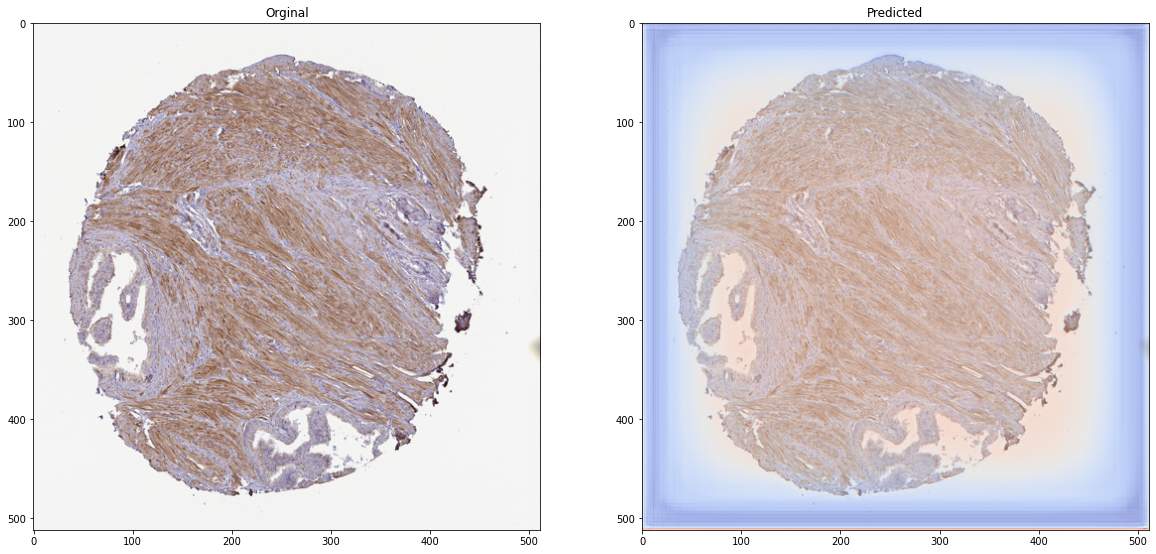

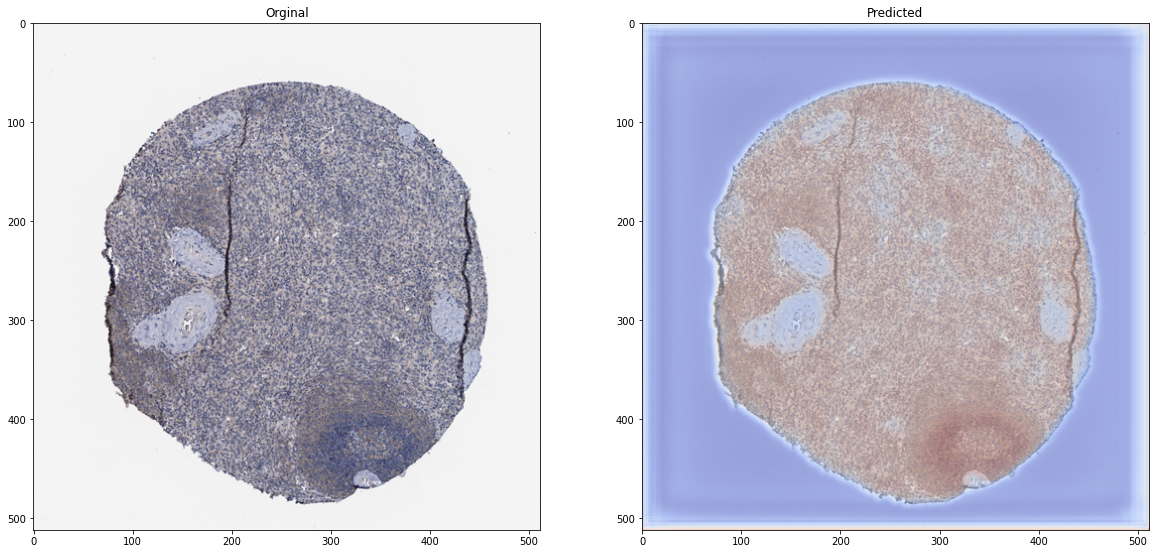

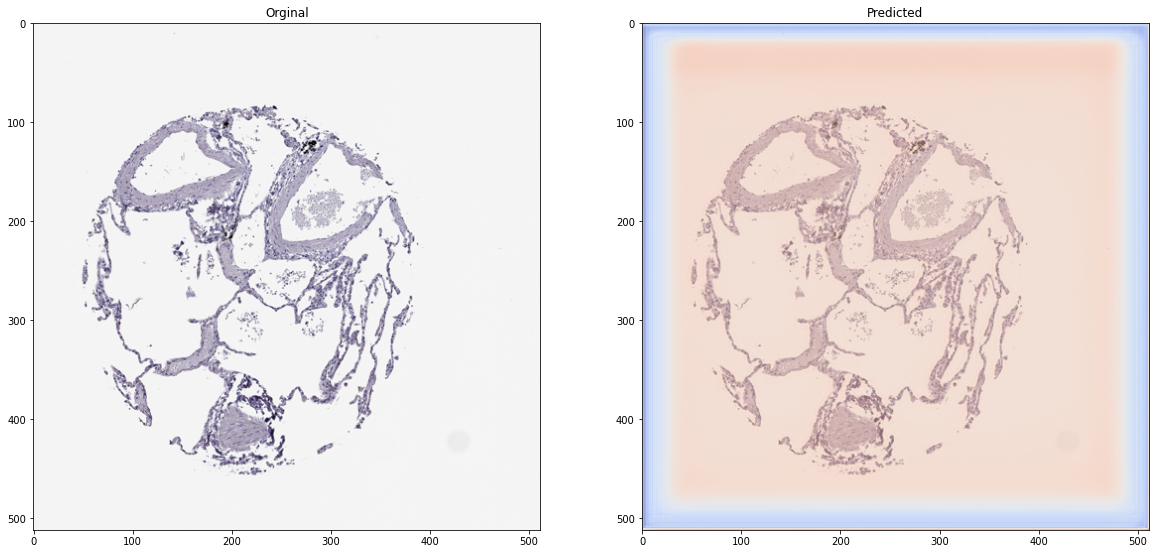

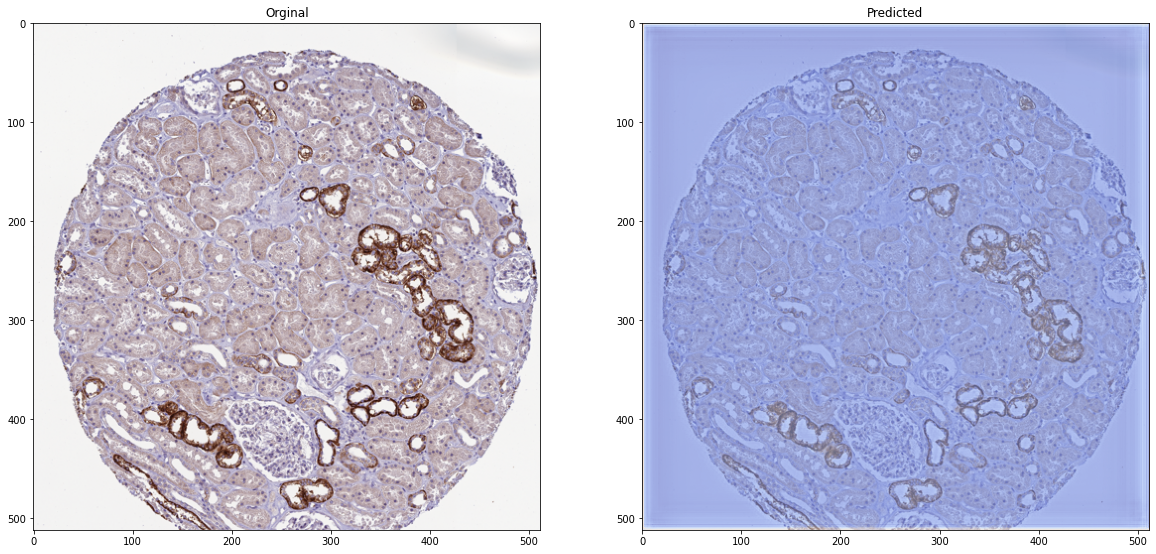

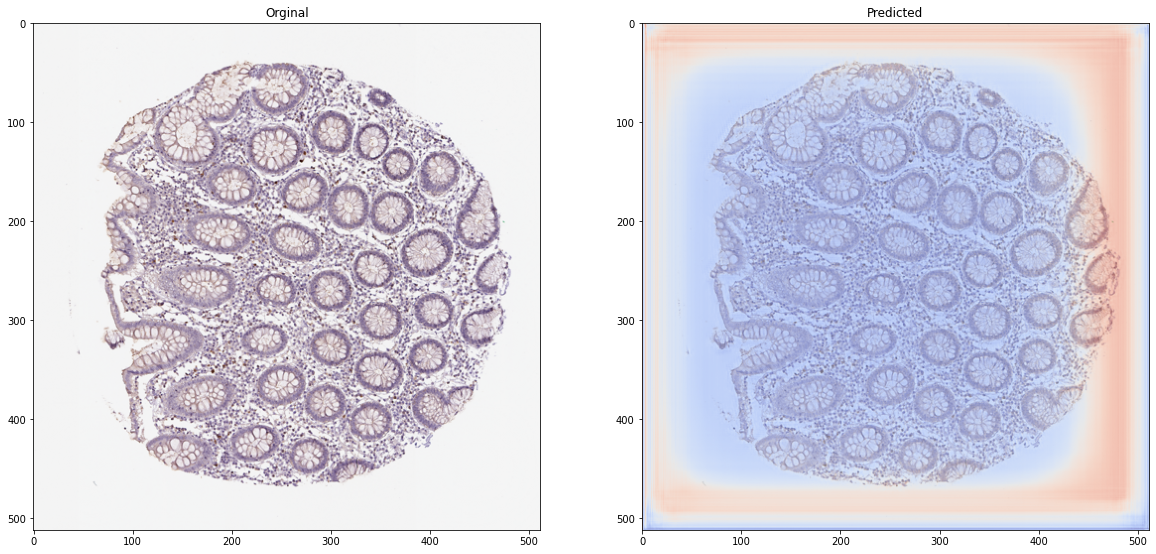

In [10]:
test_df = pd.read_csv('./test.csv')
sub = {'id':[], 'rle':[]}

for organ in organs:
    print("Predicting on organ:", organ)

    test_X = test_df[test_df.organ == organ].reset_index(drop=True)
    if len(test_X) == 0: continue #Skip organs without item in test
        
    model = load_model(f"./{organ}_model.h5", compile=False, custom_objects={"bce_dice_loss": bce_dice_loss, "dice_coef": dice_coef})
    
    test_loader = ImageDataGenerator(test_X, batch_size, False,512)
    preds = model.predict(test_loader)
    rle = [mask2rle(m, d) for m,d in zip(preds.round(), test_X.img_width)]
    sub['id'] += test_X.id.values.tolist()
    sub['rle'] += rle

    plt.figure(figsize=(20, 20))
    plt.subplot(1, 2, 1)
    plt.title('Orginal')
    plt.imshow(test_loader[0][0])
    plt.subplot(1, 2, 2)
    plt.title('Predicted')
    plt.imshow(test_loader[0][0])
    plt.imshow(preds[0], cmap='coolwarm', alpha=0.5)

# APP

In [5]:
app = Flask(__name__)
@app.route('/')

def hello_world():
    return render_template("page/app.html")